# Importing Libraries

In [34]:
import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad
import requests
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Prediction fn

In [35]:
def get_predictions(pred,threshold=0.8,objects=None ):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]
    
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

# Draw box without probability fn 

In [36]:

def draw(predicted_classes, image, rect_th=2, text_size=1, text_th=2):
    """
    Draws a box around each object.
    
    predicted_classes: list of tuples where each tuple contains:
                       (class_name, probability, bounding_box).
    image: image in tensor format (PyTorch).
    rect_th: thickness of rectangle.
    text_size: size of the text.
    text_th: thickness of the text.
    """
    
    # Convert and prepare the image for drawing
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), 
                                cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

    # Iterate over the predicted classes and draw boxes
    for predicted_class in predicted_classes:
        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]  # This should be a list or tuple with format [(x_min, y_min), (x_max, y_max)]
        
        # Unpack and ensure coordinates are integers
        (x_min, y_min), (x_max, y_max) = box
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
        
        # Draw the rectangle around the object
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), rect_th)  # Rectangle with coordinates
        
        # Draw the label with probability above the rectangle
        cv2.putText(img, f"{label}: ", (x_min, y_min - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
    
    # Display the image with drawn boxes
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # Clean up
    del img
    del image

# Draw box with probability fn 

In [37]:
def draw_box(predicted_classes, image, rect_th=2, text_size=1, text_th=2):
    """
    Draws a box around each object.
    
    predicted_classes: list of tuples where each tuple contains:
                       (class_name, probability, bounding_box).
    image: image in tensor format (PyTorch).
    rect_th: thickness of rectangle.
    text_size: size of the text.
    text_th: thickness of the text.
    """
    
    # Convert and prepare the image for drawing
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), 
                                cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

    # Iterate over the predicted classes and draw boxes
    for predicted_class in predicted_classes:
        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]  # This should be a list or tuple with format [(x_min, y_min), (x_max, y_max)]
        
        # Unpack and ensure coordinates are integers
        (x_min, y_min), (x_max, y_max) = box
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
        
        # Draw the rectangle around the object
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), rect_th)  # Rectangle with coordinates
        
        # Draw the label with probability above the rectangle
        cv2.putText(img, f"{label}: {round(probability, 2)}", (x_min, y_min - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
    
    # Display the image with drawn boxes
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # Clean up
    del img
    del image

# Free RAM space fn

In [38]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

In [39]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

done


# Faster model run fn

In [40]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

# Common objects classes

In [41]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

# Detecting objects fn

In [42]:
def detect(img_path = None,url= None ,threshold=0.7) :
    if url == None :
        image = Image.open(img_path)
        del img_path
    else :
        image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
        del url
    half = 0.5
    image.resize( [int(half * s) for s in image.size] )
    plt.imshow(np.array(image))
    plt.show()
    
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(image)
    pred = model([img])
    pred_thresh=get_predictions(pred,threshold)
    draw(pred_thresh,img)
    draw_box(pred_thresh,img)
    del pred_thresh

# Testing photos on local machine

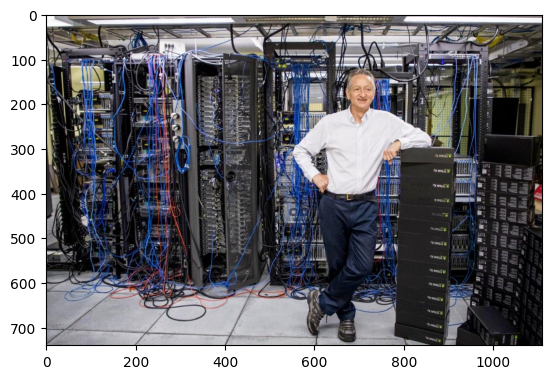

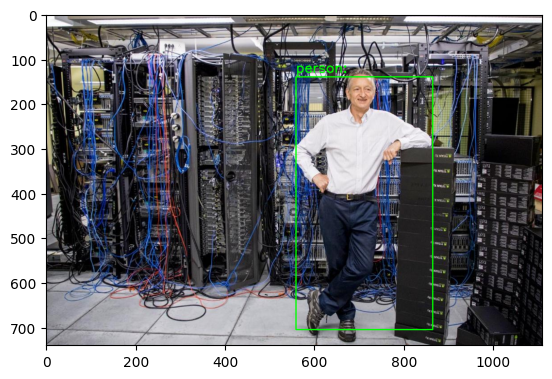

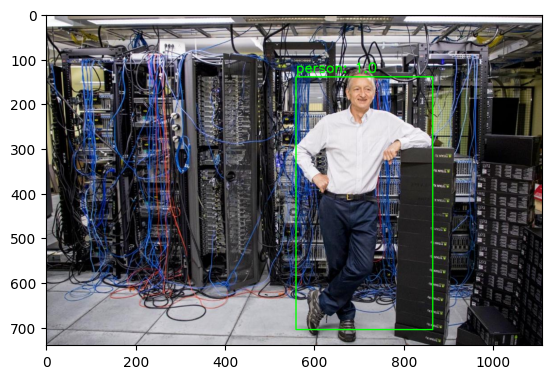

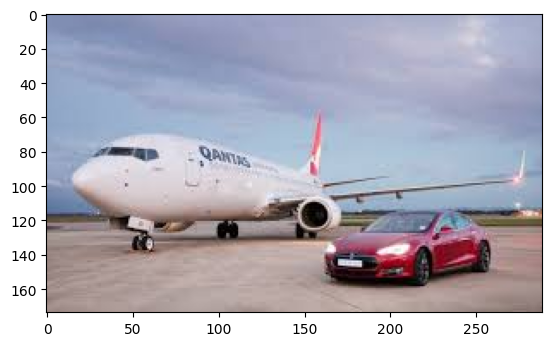

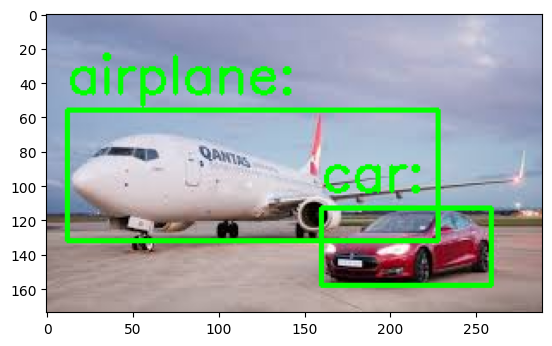

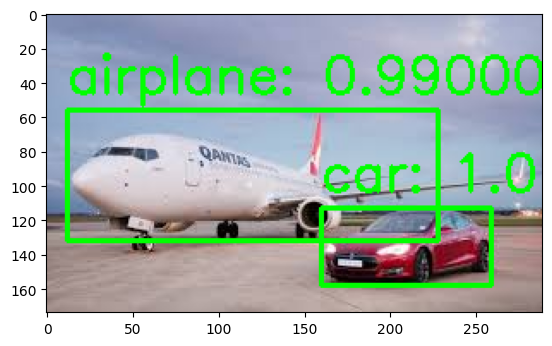

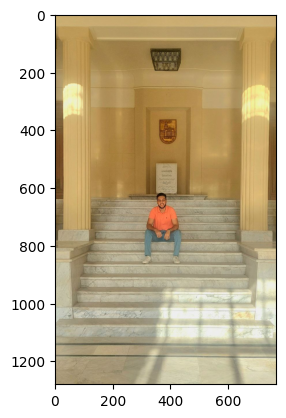

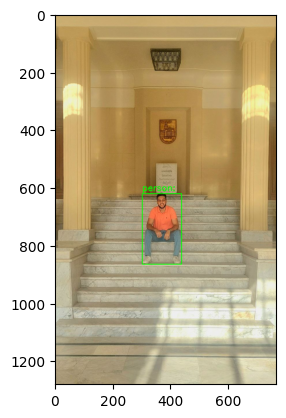

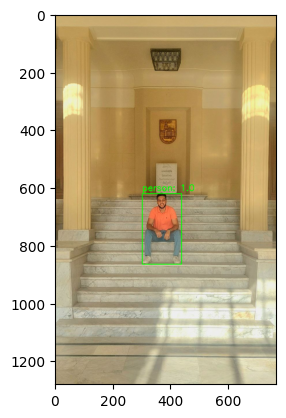

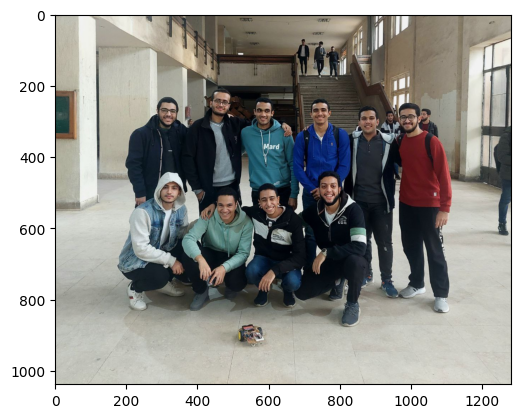

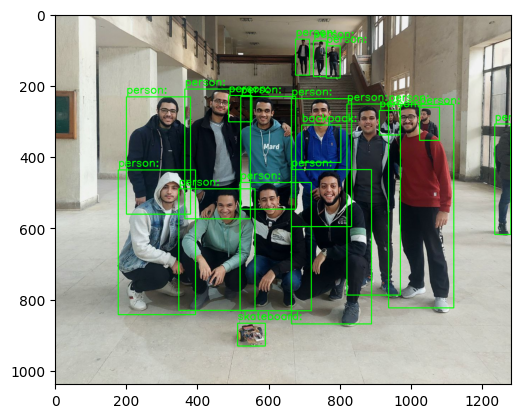

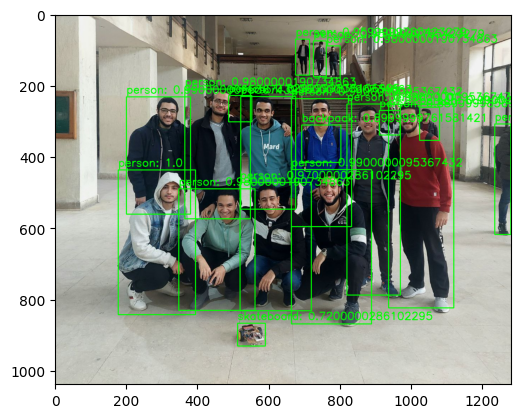

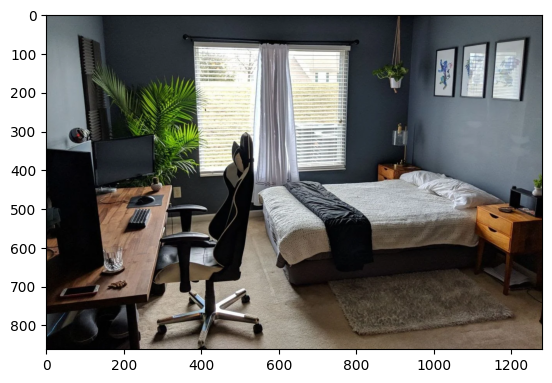

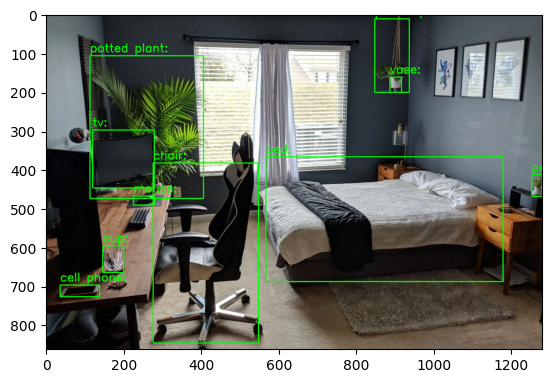

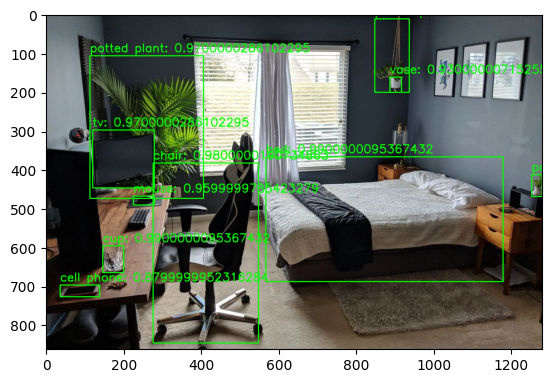

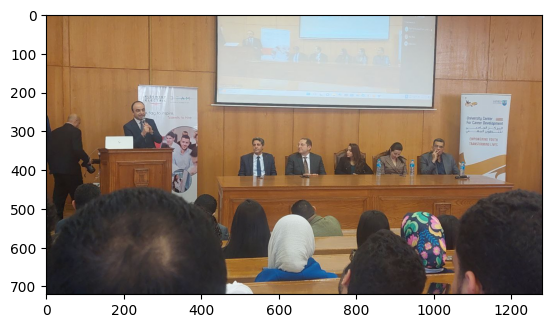

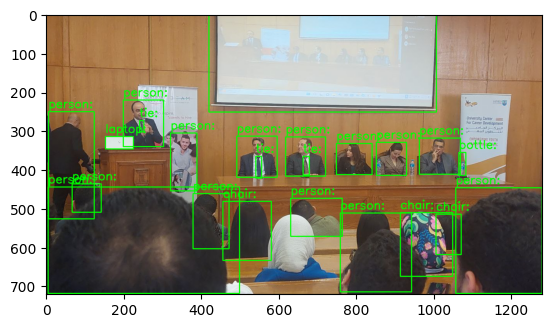

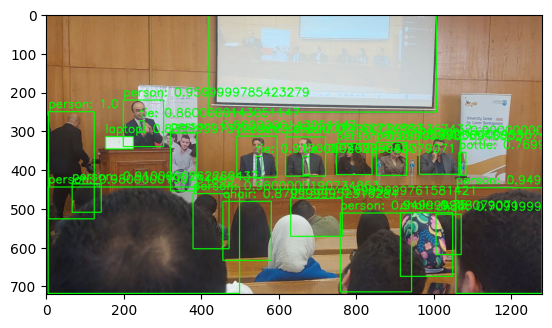

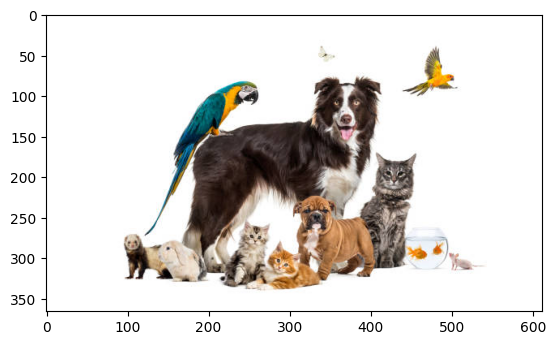

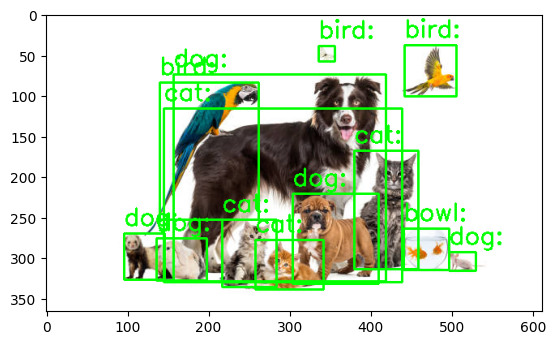

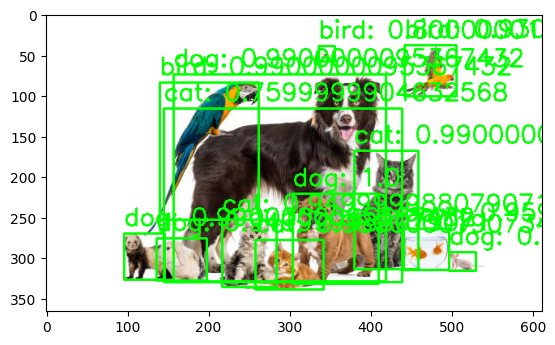

In [43]:
# the photos are provided with the code 

detect(r'C:\Users\mazen\OneDrive\Pictures\jeff.jpg')
detect(r'C:\Users\mazen\OneDrive\Pictures\car.jpg')
detect(r'C:\Users\mazen\OneDrive\Pictures\me.jpg')
detect(r'C:\Users\mazen\OneDrive\Pictures\team.jpg')
detect(r'C:\Users\mazen\OneDrive\Pictures\THE HOME.jpg')
detect(r'C:\Users\mazen\OneDrive\Pictures\event.jpg')
detect(r'C:\Users\mazen\OneDrive\Pictures\object.jpg')

# Testing online photo

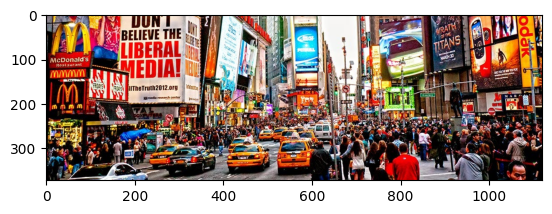

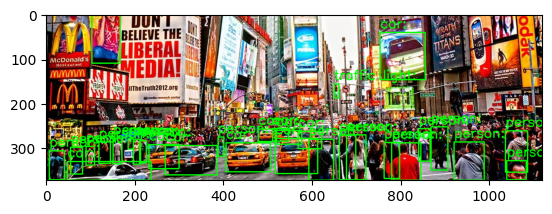

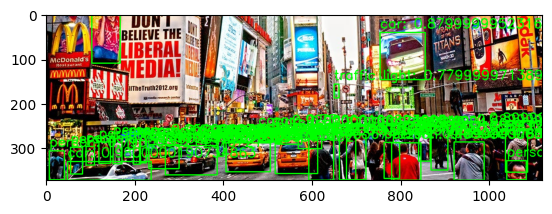

In [44]:
detect(url = "https://www.introducingnewyork.com/f/estados-unidos/nueva-york/guia/times-square.jpg")